In [99]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

In [100]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [101]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [104]:
def dj(case, n):
    oracle = dj_oracle(case,n)
    dj_circuit = dj_algorithm(oracle,n)
    print("Non Transpiled Circuit")
    print(dj_circuit)
    aer_sim = Aer.get_backend('aer_simulator')
    tranpiled_dj = transpile(dj_circuit, aer_sim)
    print("Transpiled Circuit")
    print(tranpiled_dj)
    return  dj_circuit, tranpiled_dj

Non Transpiled Circuit
     ┌───┐     ┌─────────┐┌───┐┌─┐      
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├──────
     ├───┤     │         │├───┤└╥┘┌─┐   
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├───
     ├───┤     │  Oracle │├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─────┤2        ├┤ H ├─╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║ └╥┘
q_3: ┤ X ├┤ H ├┤3        ├──────╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║ 
c: 3/═══════════════════════════╩══╩══╩═
                                0  1  2 
Transpiled Circuit
      ┌─────────┐      ┌───────────┐     ┌─┐           
q_0: ─┤ U2(0,0) ├───■──┤ U2(-π,-π) ├─────┤M├───────────
      └──┬───┬──┘   │  └───────────┘┌───┐└╥┘     ┌─┐   
q_1: ────┤ H ├──────┼────────■──────┤ H ├─╫──────┤M├───
         ├───┤      │        │      └───┘ ║ ┌───┐└╥┘┌─┐
q_2: ────┤ H ├──────┼────────┼────────■───╫─┤ H ├─╫─┤M├
     ┌───┴───┴───┐┌─┴─┐    ┌─┴─┐    ┌─┴─┐ ║ └───┘ ║ └╥┘
q_3: ┤ U2(-π,-π) ├┤ X ├────┤ X ├────┤ X ├─╫───────╫──╫─
     └───────────┘└───┘    └───┘    └───┘ ║       ║  ║ 
c: 

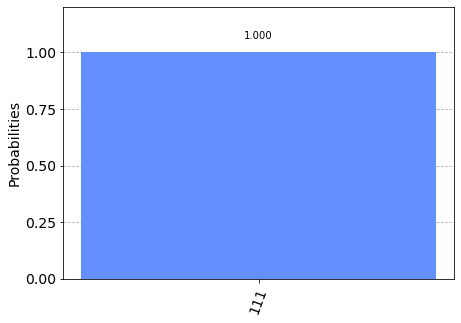

In [105]:
dj_circuit, transpiled_dj_circuit = dj("balanced", 3)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

In [106]:
print(QuantumCircuit.count_ops(transpiled_dj_circuit))

OrderedDict([('h', 4), ('u2', 3), ('cx', 3), ('measure', 3)])


In [93]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_belem


In [107]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


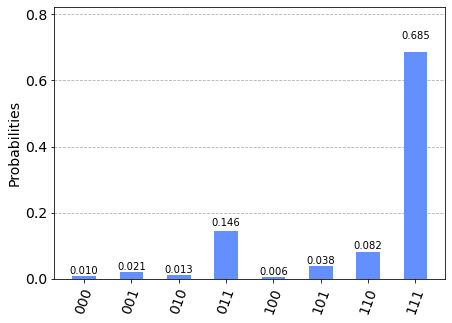

In [108]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

In [109]:
print(transpiled_dj_circuit)

               ┌─────────┐ ┌────┐ ┌───────┐                            ┌────┐  »
      q_2 -> 0 ┤ Rz(π/2) ├─┤ √X ├─┤ Rz(π) ├──────────────────■─────────┤ √X ├──»
               ├─────────┤ ├────┤┌┴───────┴─┐┌───┐┌───┐    ┌─┴─┐       └────┘  »
      q_3 -> 1 ┤ Rz(π/2) ├─┤ √X ├┤ Rz(-π/2) ├┤ X ├┤ X ├────┤ X ├───────────────»
               ├─────────┤ ├────┤└┬───────┬─┘└─┬─┘└─┬─┘    ├───┴┐   ┌─────────┐»
      q_1 -> 2 ┤ Rz(π/2) ├─┤ √X ├─┤ Rz(π) ├────┼────■──────┤ √X ├───┤ Rz(π/2) ├»
               ├─────────┴┐├────┤ ├───────┤    │  ┌────┐┌──┴────┴──┐└───┬─┬───┘»
      q_0 -> 3 ┤ Rz(-π/2) ├┤ √X ├─┤ Rz(π) ├────■──┤ √X ├┤ Rz(-π/2) ├────┤M├────»
               └──────────┘└────┘ └───────┘       └────┘└──────────┘    └╥┘    »
ancilla_0 -> 4 ──────────────────────────────────────────────────────────╫─────»
                                                                         ║     »
          c: 3/══════════════════════════════════════════════════════════╩═════»
                            